In [3]:
import numpy as np
import cv2
# import skimage
import matplotlib.pyplot as plt
import src.cp_hw2
# import src.cp_exr

# 1. HDR imaging

## Linearize rendered images

In [4]:
path_list = ['data/door_stack/exposure'+str(i)+'.jpg' for i in range(1,17)]
img_stack_jpg_for_g = []
for path in path_list : 
    img = plt.imread(path)
    #sample the image to reduce the size
    img = img[::200, ::200]
    img_stack_jpg_for_g.append(img)
img_stack_jpg_for_g = np.array(img_stack_jpg_for_g)
img_stack_jpg_reshaped_for_g = img_stack_jpg_for_g.reshape(img_stack_jpg_for_g.shape[0],-1).swapaxes(0,1)


In [5]:
def recover_g(imgs_stack_reshaped, images_stack, w, t, r_l=1, is_w_photon=False):
    n = 256
    num_rows = imgs_stack_reshaped.shape[0] * imgs_stack_reshaped.shape[1] + n + 1
    num_cols = n + imgs_stack_reshaped.shape[0]
    
    A = np.zeros((num_rows, num_cols))
    b = np.zeros((num_rows, 1))
    cur_row_A = 0
    
    # Populate matrix A and vector b
    for i in range(imgs_stack_reshaped.shape[0]):
        for j in range(imgs_stack_reshaped.shape[1]):
            wt_ij = w(imgs_stack_reshaped[i, j], t[j]) if is_w_photon else w(imgs_stack_reshaped[i, j])
            A[cur_row_A, imgs_stack_reshaped[i, j]] = wt_ij
            A[cur_row_A, n + i - 1] = -wt_ij
            b[cur_row_A, 0] = wt_ij * np.log(t[j])
            cur_row_A += 1
    
    # Add smoothing regularization terms
    for i in range(n):
        wt_i = 1 if is_w_photon else w(i)
        A[cur_row_A,i-1] = r_l * wt_i
        A[cur_row_A,i] = -2*r_l*wt_i
        A[cur_row_A,i+1] = r_l*wt_i
        cur_row_A += 1 
    
    # Normalize the curve
    A[cur_row_A, 128] = 1
    
    # Solve the least squares problem
    v_sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    g = v_sol[:n]
    
    return g

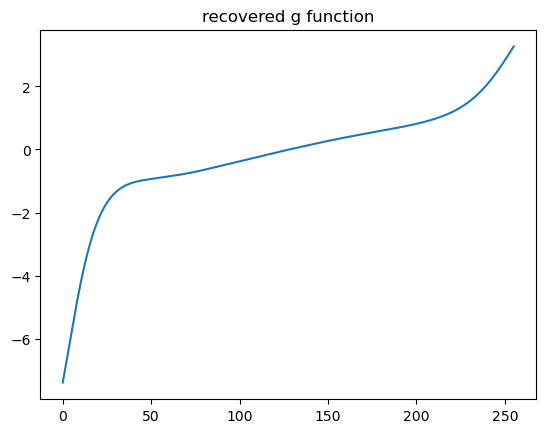

In [7]:
# Function to calculate exposure times
exptime = lambda x: 2.0 ** (x - 1 - 11)
exptime_list = [exptime(i) for i in range(1, 17)]

# Weight function
w = lambda x, zmin=0.05, zmax=0.95: 0.01

# Calculate g-values
g = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w, exptime_list, 1000)

# Plotting g
plt.plot(np.arange(0,256),g)
plt.title('recovered g function')
plt.show()

In [14]:
# Linearizing the image
path_list = ['data/door_stack/exposure'+str(i)+'.jpg' for i in range(1,17)]
imgs_stack_jpg = []
for path in path_list : 
    img = plt.imread(path)
    img = img[::20, ::20]
    # img = img[::5, ::5]
    imgs_stack_jpg.append(img)
imgs_stack_jpg = np.array(imgs_stack_jpg)

def linearize_image(images_stack, g) : 
    lin_images_stack = np.exp(g[images_stack])
    lin_images_stack = lin_images_stack.squeeze(-1)
    return lin_images_stack

imgs_stack_linear = linearize_image(imgs_stack_jpg, g)
# plt.imshow(imgs_stack_linear[14])


## Merge exposure stack into HDR image

In [15]:
# Load the tiff images
path_list = ['data/door_stack/exposure'+str(i)+'.tiff' for i in range(1,17)]
imgs_stack_tiff = []
for path in path_list :
#     img = plt.imread(imf)
    # TO CHANGE TODOOOOO
    img = cv2.imread(path, -1)
    img = img[...,::-1]
    img = img[::5, ::5]
    imgs_stack_tiff.append(img)
imgs_stack_tiff = np.array(imgs_stack_tiff)

# Normalize the images
imgs_stack_jpg_normalized = imgs_stack_jpg / 255.0
imgs_stack_tiff_normalized = imgs_stack_tiff / (2**16 - 1)

In [16]:
def linear_merging(img_stack, img_stack_linear, exposure_times, weight_vector, is_w_photon=False) :
    
    img_hdr_num = np.zeros(img_stack[0].shape)
    img_hdr_den = np.zeros(img_stack[0].shape)

    for k in range(len(img_stack)) :
        if is_w_photon : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_vector(img_stack[k],exposure_times[k],0.02, 0.98)
            else : 
                w_v_imk = weight_vector(img_stack[k],exposure_times[k])
        else : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_vector(img_stack[k], 0.02, 0.98)
            else : 
                w_v_imk = weight_vector(img_stack[k])
        img_hdr_num += (w_v_imk * img_stack_linear[k] / exposure_times[k] ) 
        img_hdr_den += (w_v_imk)
    
    img_hdr = img_hdr_num / img_hdr_den
    
    # if img_hdr_num == 0, img_hdr should also be zero
    img_hdr_num_zero = np.where(img_hdr_num == 0)
    if len(img_hdr_num_zero) == 3 : 
        img_hdr_num_zero = np.vstack((np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])), img_hdr_num_zero[2])).T
    else : 
        img_hdr_num_zero = np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])).T
        
        
    # if only img_hdr_den is zero, img_hdr should be max val
    img_hdr_den_zero = np.where(img_hdr_den == 0)
    if len(img_hdr_den_zero) == 3 : 
        img_hdr_den_zero = np.vstack((np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])), img_hdr_den_zero[2])).T
    else : 
        img_hdr_den_zero = np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])).T
    
    img_hdr_max_val = []
    
    if img_hdr_num_zero.size > 0 :
        if len(img_hdr.shape) == 3 : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1],img_hdr_num_zero[:,2]] = 0
        else : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1]] = 0
    
    if img_hdr_den_zero.size > 0 :
        for index in img_hdr_den_zero :
            if len(img_hdr.shape) == 3 : 
                if img_hdr_num[index[0],index[1],index[2]] != 0 :
                    img_hdr_max_val.append(index)
            else : 
                if img_hdr_num[index[0],index[1]] != 0 :
                    img_hdr_max_val.append(index)
                
        img_hdr_max_val = np.array(img_hdr_max_val).T
        if img_hdr_max_val.size > 0 :
            if len(img_hdr.shape) == 3 : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1],img_hdr_max_val[:,2]] = img_hdr.nanmax()
            else : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1]] = img_hdr.nanmax()
    
    return img_hdr


def logarithmic_merging(img_stack, img_stack_linear, exposure_times, weight_fucntion, is_w_photon=False) :
    
    eps = 1e-8
    img_hdr_num = np.zeros(img_stack[0].shape)
    img_hdr_den = np.zeros(img_stack[0].shape)

    for k in range(len(img_stack)) :        
        if is_w_photon : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_fucntion(img_stack[k],exposure_times[k],0.02, 0.98)
            else : 
                w_v_imk = weight_fucntion(img_stack[k],exposure_times[k])
        else : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_fucntion(img_stack[k], 0.02, 0.98)
            else : 
                w_v_imk = weight_fucntion(img_stack[k])
        img_hdr_num += ( w_v_imk * ( np.log(img_stack_linear[k] + eps) - np.log(exposure_times[k]))) 
        img_hdr_den += w_v_imk
        
    img_hdr = img_hdr_num / img_hdr_den

    # if img_hdr_num == 0, img_hdr should also be zero
    img_hdr_num_zero = np.where(img_hdr_num == 0)
    img_hdr_num_zero = np.vstack((np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])), img_hdr_num_zero[2])).T
    
    # if only img_hdr_den is zero, img_hdr should be max val
    img_hdr_den_zero = np.where(img_hdr_den == 0)
    img_hdr_den_zero = np.vstack((np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])), img_hdr_den_zero[2])).T
    img_hdr_max_val = []
    
    if img_hdr_num_zero.size > 0 :
        img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1],img_hdr_num_zero[:,2]] = 0
    
    if img_hdr_den_zero.size > 0 :
        for index in img_hdr_den_zero :
            if img_hdr_num[index[0],index[1],index[2]] != 0 :
                img_hdr_max_val.append(index)
        img_hdr_max_val = np.array(img_hdr_max_val).T
        if img_hdr_max_val.size > 0 :
            img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1],img_hdr_max_val[:,2]] = img_hdr.nanmax()
        
    return np.exp(img_hdr)


## Weighting schemes

In [17]:
def w_uniform(z, Z_min = 0.05, Z_max=0.95) :
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return 1
    return 0

def w_tent(z, Z_min = 0.001, Z_max=0.999) :
    if isinstance(z,np.uint8) or isinstance(z,int) : 
        z = z / 255.0

    if Z_min <= z <= Z_max :
        return np.min([z, 1.0-z])
    return 0

def w_gaussian(z, Z_min = 0.001, Z_max=0.999) :
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return np.exp(-4 * (((z-0.5)**2) / ((0.5)**2)))
    return 0

def w_photon(z, tk, Z_min = 0.05, Z_max=0.95) : 
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return tk
    return 0
    

In [18]:
w_uniform_vect = np.vectorize(w_uniform)
w_tent_vect = np.vectorize(w_tent)
w_gaussian_vect = np.vectorize(w_gaussian)
w_photon_vect = np.vectorize(w_photon)

In [19]:
# Merge raw images
img_hdr_tiff_lin_merged_w_uniform = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_uniform_vect)
img_hdr_tiff_lin_merged_w_tent = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_tent_vect)
img_hdr_tiff_lin_merged_w_gaussian = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_gaussian_vect)
img_hdr_tiff_lin_merged_w_photon = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_photon_vect, is_w_photon=True)

img_hdr_tiff_log_merged_w_uniform = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_uniform_vect)
img_hdr_tiff_log_merged_w_tent = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_tent_vect)
img_hdr_tiff_log_merged_w_gaussian = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_gaussian_vect)
img_hdr_tiff_log_merged_w_photon = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_photon_vect, is_w_photon=True)

/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_76653/3132380889.py:20: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den
/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_76653/3132380889.py:84: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den


In [20]:
# HDR display util functions
def linear_scaling(img, scale):
    img_scaled = np.clip(img * scale, 0, 1)
    return img_scaled

def gamma_encoding(x) : 
    if x <= 0.0031308 : 
        return 12.92 * x
    else : 
        return (1+0.055) * np.power(x, 1/2.4) - 0.055

def display_hdr(img, scale, title='') : 
    img_scaled = linear_scaling(img, scale)
    gamma_encoding_vect = np.vectorize(gamma_encoding)
    image_ge = gamma_encoding_vect(img_scaled)

    plt.imshow(image_ge)
    plt.title(title)
    plt.show()

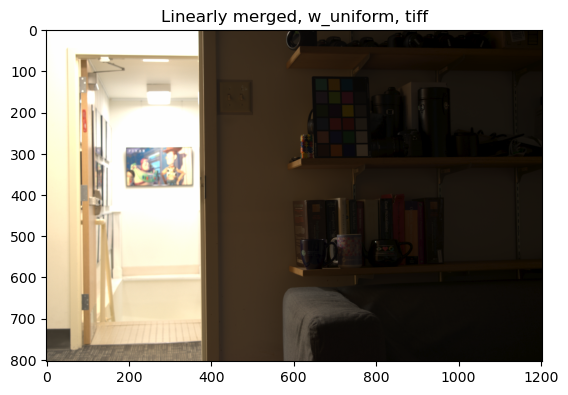

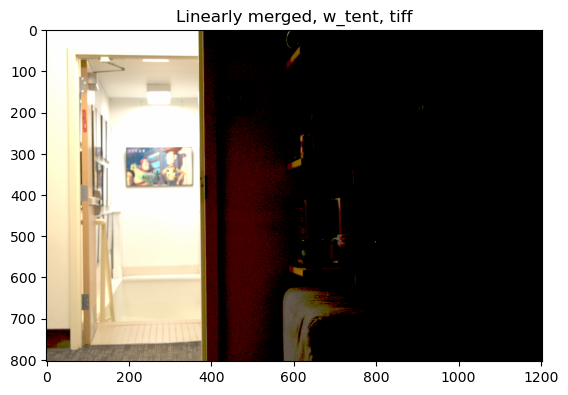

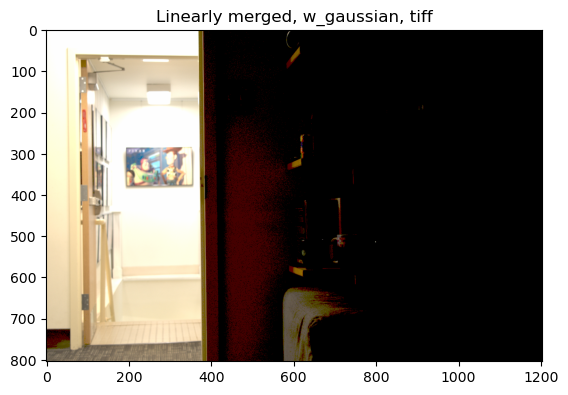

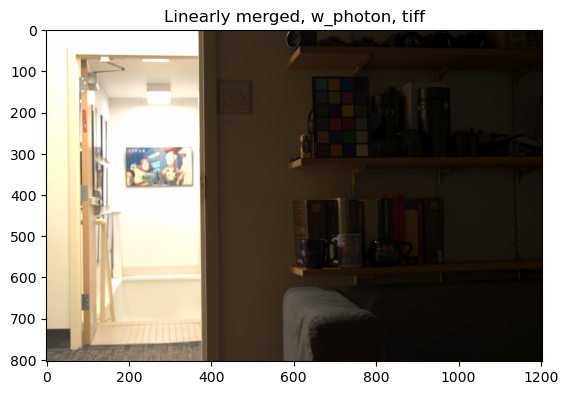

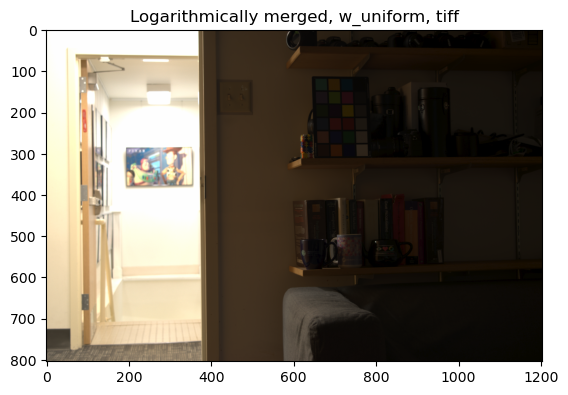

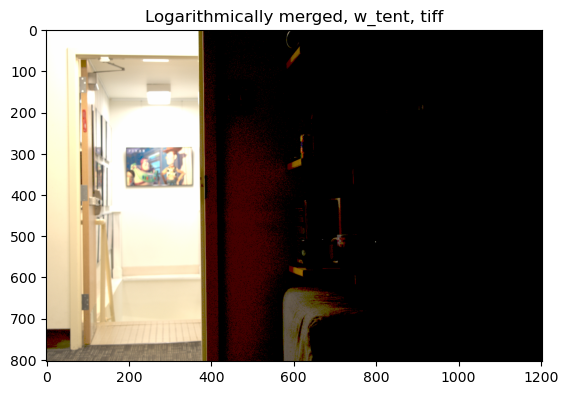

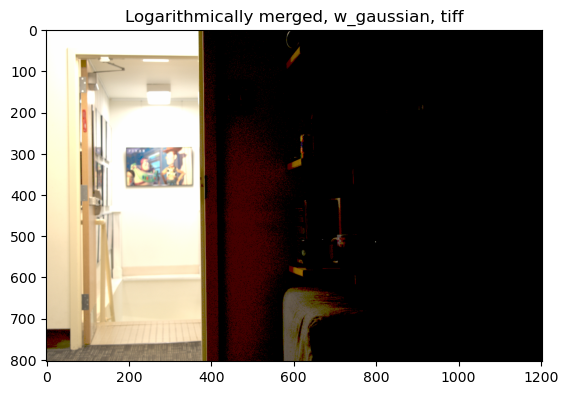

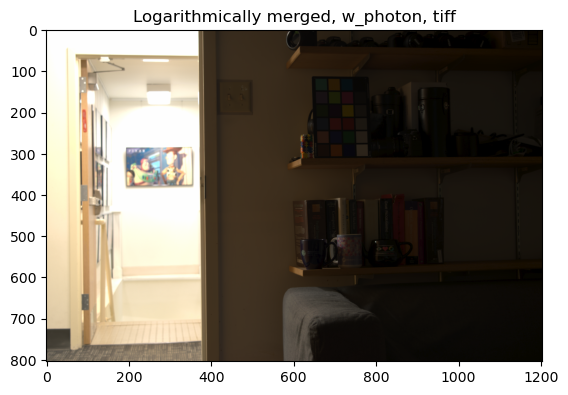

In [21]:
# Display tiff hdr images
display_hdr(img_hdr_tiff_lin_merged_w_uniform,0.00002,'Linearly merged, w_uniform, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_tent,0.00002,'Linearly merged, w_tent, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_gaussian,0.00002,'Linearly merged, w_gaussian, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_photon,0.00002,'Linearly merged, w_photon, tiff')

display_hdr(img_hdr_tiff_log_merged_w_uniform,0.00002,'Logarithmically merged, w_uniform, tiff')
display_hdr(img_hdr_tiff_log_merged_w_tent,0.00002,'Logarithmically merged, w_tent, tiff')
display_hdr(img_hdr_tiff_log_merged_w_gaussian,0.00002,'Logarithmically merged, w_gaussian, tiff')
display_hdr(img_hdr_tiff_log_merged_w_photon,0.00002,'Logarithmically merged, w_photon, tiff')


In [22]:
# First linearlize then Merge jpg images
g_uniform = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_uniform_vect,exptime_list, 1000)
g_tent = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_tent_vect,exptime_list, 1000)
g_gaussian = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_gaussian_vect,exptime_list, 1000)
g_photon = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_photon_vect,exptime_list, 1000, is_w_photon=True)

imgs_linear_stack_uniform = linearize_image(imgs_stack_jpg, g_uniform)
imgs_linear_stack_tent = linearize_image(imgs_stack_jpg, g_tent)
imgs_linear_stack_gaussian = linearize_image(imgs_stack_jpg, g_gaussian)
imgs_linear_stack_photon = linearize_image(imgs_stack_jpg, g_photon)


In [23]:
img_hdr_jpeg_lin_merged_w_uniform = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_uniform, exptime_list, w_uniform_vect)
img_hdr_jpeg_lin_merged_w_tent = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_tent, exptime_list, w_tent_vect)
img_hdr_jpeg_lin_merged_w_gaussian = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_gaussian, exptime_list, w_gaussian_vect)
img_hdr_jpeg_lin_merged_w_photon = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_photon, exptime_list, w_photon_vect, is_w_photon=True)

img_hdr_jpeg_log_merged_w_uniform = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_uniform, exptime_list, w_uniform_vect)
img_hdr_jpeg_log_merged_w_tent = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_tent, exptime_list, w_tent_vect)
img_hdr_jpeg_log_merged_w_gaussian = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_gaussian, exptime_list, w_gaussian_vect)
img_hdr_jpeg_log_merged_w_photon = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_photon, exptime_list, w_photon_vect, is_w_photon=True)

/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_76653/3132380889.py:20: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den
/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_76653/3132380889.py:84: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den


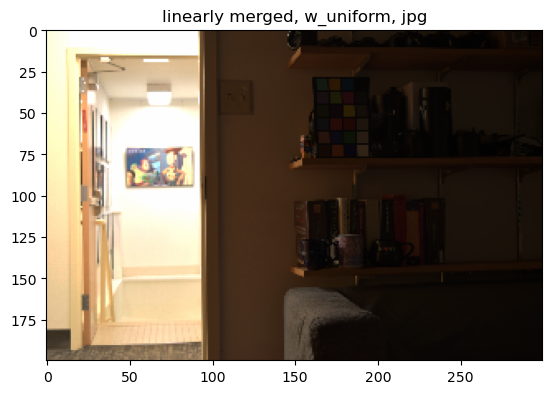

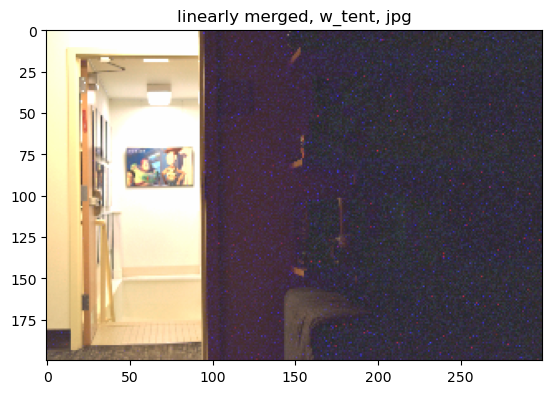

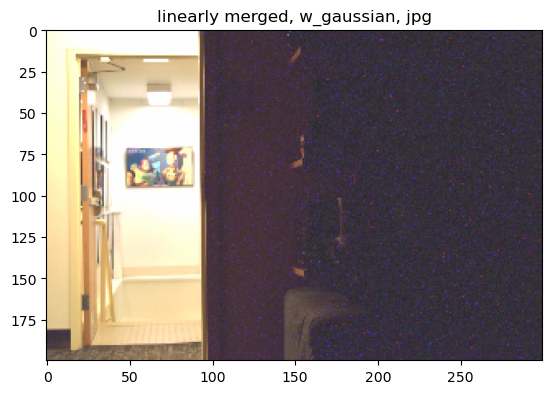

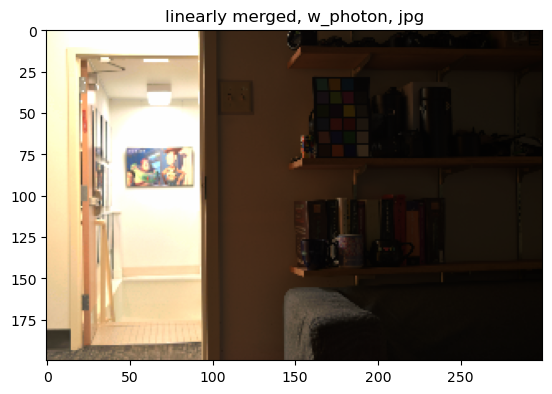

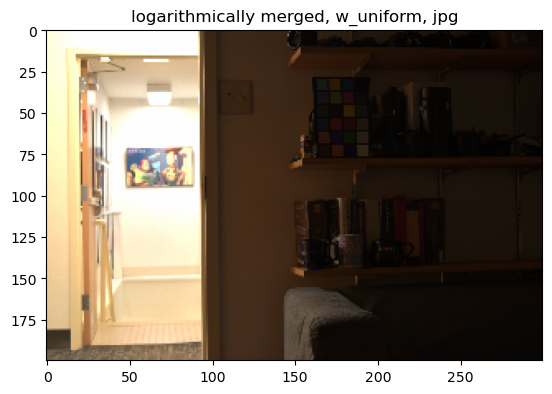

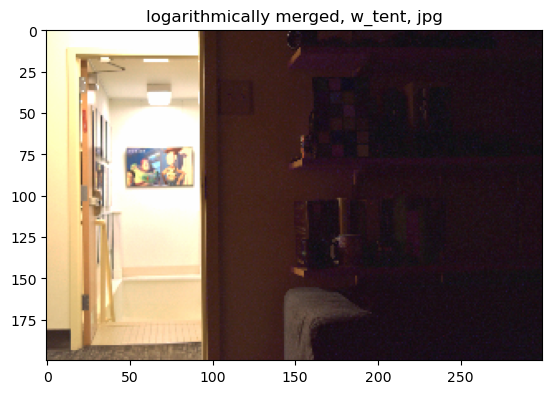

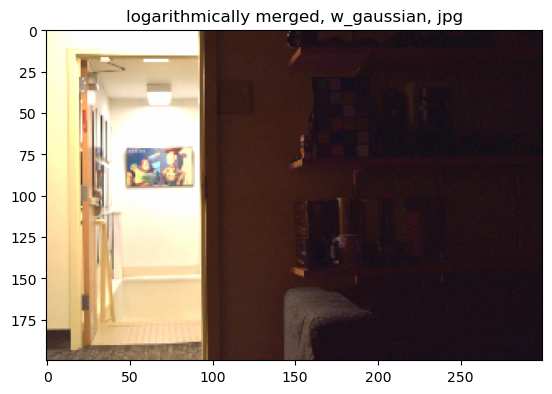

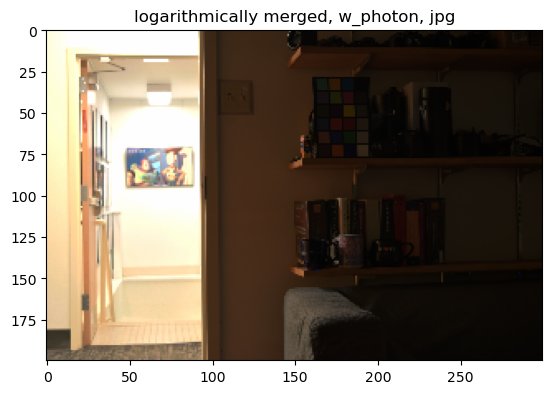

In [25]:
display_hdr(img_hdr_jpeg_lin_merged_w_uniform,0.1,'linearly merged, w_uniform, jpg')
display_hdr(img_hdr_jpeg_lin_merged_w_tent,0.1,'linearly merged, w_tent, jpg')
display_hdr(img_hdr_jpeg_lin_merged_w_gaussian,0.1,'linearly merged, w_gaussian, jpg')
display_hdr(img_hdr_jpeg_lin_merged_w_photon,0.1,'linearly merged, w_photon, jpg')

display_hdr(img_hdr_jpeg_log_merged_w_uniform,0.1,'logarithmically merged, w_uniform, jpg')
display_hdr(img_hdr_jpeg_log_merged_w_tent,0.1,'logarithmically merged, w_tent, jpg')
display_hdr(img_hdr_jpeg_log_merged_w_gaussian,0.1,'logarithmically merged, w_gaussian, jpg')
display_hdr(img_hdr_jpeg_log_merged_w_photon,0.1,'logarithmically merged, w_photon, jpg')

In [33]:
src.cp_hw2.writeHDR('output/part1.hdr', img_hdr_tiff_lin_merged_w_photon)

# 2. Color correction and white balancing

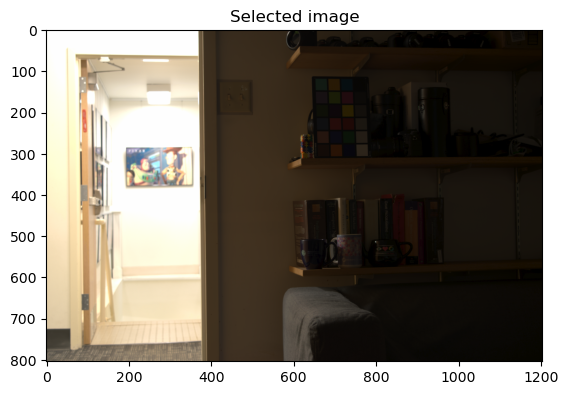

In [27]:
# Copy the selected HDR image for further processing
img_hdr_selected = img_hdr_tiff_lin_merged_w_photon.copy()

# Display the selected HDR image
display_hdr(img_hdr_selected, 0.00002, 'Selected image')

# Read the ground truth color checker
color_checker_gt = src.cp_hw2.read_colorchecker_gm()

# Reshape the color checker ground truth array for easier manipulation
# The array goes from the bottom-left corner to the top-right corner, column-wise
temp = np.stack((color_checker_gt[0], color_checker_gt[1]), axis=2)
color_checker_gt = np.concatenate((temp, np.expand_dims(color_checker_gt[2], 2)), axis=-1)

# Initialize an empty list to store the reshaped color checker ground truth
color_checker_gt_vec = []

# Loop through each column and then each row (cell) in that column
for ccvs in color_checker_gt:  # Loop through columns
    for ccv in ccvs:  # Loop through each row in the current column
        color_checker_gt_vec.append(ccv)

# Convert the list to a NumPy array for further processing
color_checker_gt_vec = np.array(color_checker_gt_vec)


In [28]:
# Row by row, left to right, Up to down
coords = np.load('selected_coords.npy')
print(coords)
coords = np.array(coords).astype('int')


[[672.93351886 298.07884972]
 [671.27612863 263.68800247]
 [669.6187384  233.02628324]
 [668.37569573 195.73500309]
 [668.37569573 163.41589363]
 [668.37569573 133.16852195]
 [705.25262832 296.00711194]
 [702.35219542 264.51669759]
 [703.5952381  235.09802103]
 [701.10915275 200.29282622]
 [702.35219542 166.31632653]
 [699.45176252 138.5550402 ]
 [737.15739023 295.59276438]
 [735.5        264.51669759]
 [735.08565244 232.61193568]
 [734.25695733 199.46413111]
 [731.77087199 170.87414966]
 [730.52782931 138.5550402 ]
 [766.99041435 292.69233148]
 [766.57606679 265.3453927 ]
 [763.26128633 232.19758813]
 [763.67563389 202.77891156]
 [762.43259122 167.97371676]
 [762.43259122 134.82591218]]


In [29]:
# Initialize an empty list to store the average colors at specified coordinates in the image
val_color_img = []

# Loop through each coordinate to extract the average color
for coord in coords:
    # Calculate the average color in a 4x4 window around the coordinate
    color_avg = img_hdr_selected[coord[1]-2:coord[1]+2, coord[0]-2:coord[0]+2].mean(axis=0).mean(axis=0)
    
    # Append the average color to the list
    val_color_img.append(color_avg)

# Convert the list of average colors to a NumPy array
val_color_img = np.array(val_color_img)

# Add a column of ones to the ground truth color checker vector
# This is often done to include a bias term in subsequent calculations
ones = np.ones((color_checker_gt_vec.shape[0], 1))
color_checker_gt_vec = np.concatenate((color_checker_gt_vec, ones), -1)

# Add a column of ones to the average colors array for the same reason
val_color_img = np.concatenate((val_color_img, ones), -1)


In [30]:
A, _, _, _ = np.linalg.lstsq(val_color_img, color_checker_gt_vec, rcond=None)
print(A)

[[ 8.14138435e-04 -6.89408057e-05  1.19075693e-05  7.94108406e-18]
 [ 1.74357642e-04  1.03948842e-03 -2.97684954e-05 -1.90819582e-17]
 [-1.60588425e-04  2.55048031e-04  1.37085811e-03  1.35525272e-17]
 [-7.06224269e-02 -1.02655626e-01 -1.04435380e-01  1.00000000e+00]]
[[ 8.20744106e-04 -8.44011269e-05  1.30955000e-05  0.00000000e+00]
 [ 1.69765199e-04  1.08366437e-03 -3.97023093e-05  0.00000000e+00]
 [-1.76793242e-04  2.15358561e-04  1.38864851e-03  0.00000000e+00]
 [-6.22932251e-02 -9.77665781e-02 -1.07127492e-01  1.00000000e+00]]


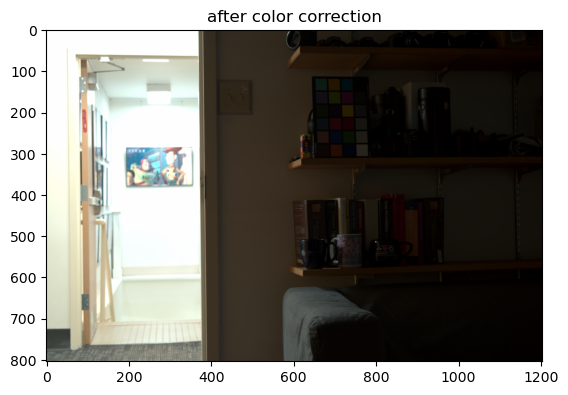

In [31]:
ones_image = np.ones([img_hdr_selected.shape[0],img_hdr_selected.shape[1],1])
im_hdr_selected_homogenous = np.concatenate((img_hdr_selected,ones_image),-1)
img_hdr_selected_cc = np.matmul(im_hdr_selected_homogenous,A)
img_hdr_selected_cc = img_hdr_selected_cc[...,:3]
display_hdr(img_hdr_selected_cc, 0.02, 'after color correction')

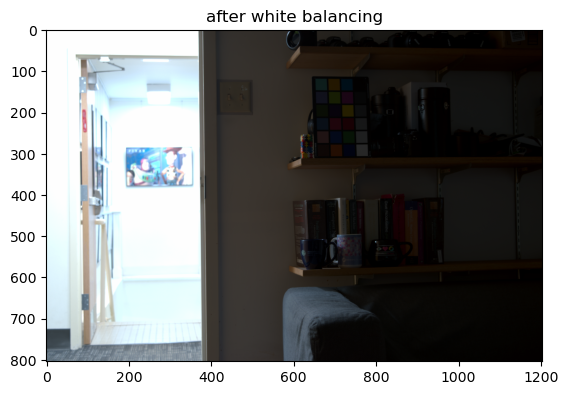

In [34]:
white_patch = img_hdr_selected_cc[coords[-6][1]-2:coords[-6][1]+2,coords[-6][0]-2:coords[-6][0]+2].mean(axis=0).mean(axis=0)
img_hdr_selected_cc_wb = img_hdr_selected_cc.copy()
img_hdr_selected_cc_wb[...,0] = img_hdr_selected_cc[...,0] * white_patch[0] / white_patch[0]
img_hdr_selected_cc_wb[...,1] = img_hdr_selected_cc[...,1] * white_patch[0] / white_patch[1]
img_hdr_selected_cc_wb[...,2] = img_hdr_selected_cc[...,2] * white_patch[0] / white_patch[2]
display_hdr(img_hdr_selected_cc_wb, 0.02, 'after white balancing')

In [35]:
src.cp_hw2.writeHDR('output/part2.hdr', img_hdr_selected_cc_wb)

# 3. Photographic tonemapping

In [32]:
# Define functions for tonemapping
def get_I_m_hdr(img) : 
    if img.min() < 0 : 
        # clipping out negative values and raising them to be over 0
        I_m_hdr = np.exp(np.log(img - (1.00000001) * img.min()).mean()) 
    else : 
        # else 
        I_m_hdr = np.exp(np.log(img + 1e5).mean()) 
    
    return I_m_hdr

def get_I_tilda_ij_hdr(I_m_hdr, im, K) : 
    I_tilda_ij_hdr= K * (im) / I_m_hdr
    return I_tilda_ij_hdr

def get_I_tilda_white(I_tilda_ij_hdr, B) : 
    I_tilda_white = B * np.max(I_tilda_ij_hdr)
    return I_tilda_white

def phtographic_tonemapping(img, K, B) :
    
    I_m_hdr = get_I_m_hdr(img)
    I_tilda_ij_hdr = get_I_tilda_ij_hdr(I_m_hdr, img, K)
    I_tilda_white = get_I_tilda_white(I_tilda_ij_hdr, B)
    
    img_tonemapped_num = I_tilda_ij_hdr * (1 + I_tilda_ij_hdr / (I_tilda_white**2))
    img_tonemapped_den = 1 + I_tilda_ij_hdr
    
    img_tonemapped = img_tonemapped_num / img_tonemapped_den
    
    return img_tonemapped

def photographic_tonemapping_xyY(img, K, B) :
    
    img_XYZ = src.cp_hw2.lRGB2XYZ(img)
    x = img_XYZ[...,0] / img_XYZ.sum(2) 
    y = img_XYZ[...,1] / img_XYZ.sum(2)
    Y = img_XYZ[...,1]
    
    Y_tonemapped = phtographic_tonemapping(Y, K, B)
    
    X = (x * Y_tonemapped) / y
    Y = Y_tonemapped
    Z = (1 - x - y) * Y_tonemapped / y
    
    img_XYZ_tonemapped = np.concatenate((np.stack((X,Y),-1),np.expand_dims(Z,-1)),-1)   
    img_RGB_tonemapped = src.cp_hw2.XYZ2lRGB(img_XYZ_tonemapped)
    
    return img_RGB_tonemapped

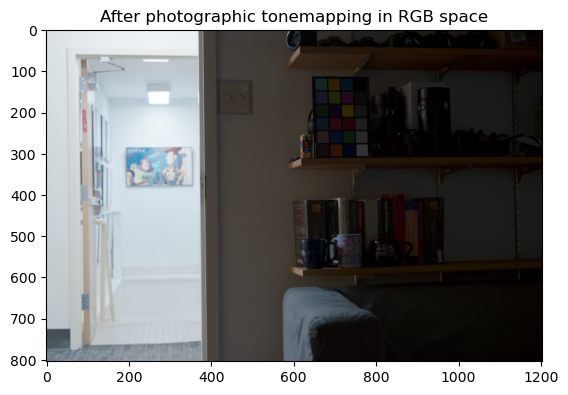

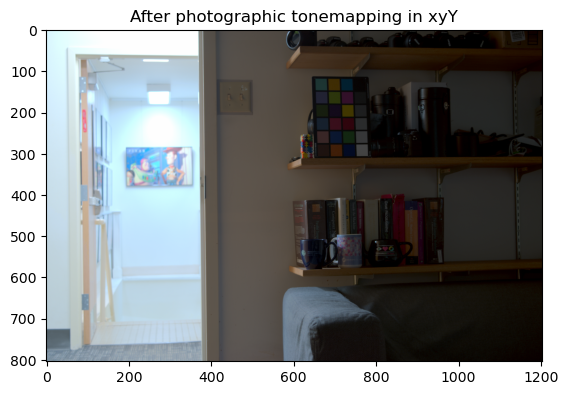

In [36]:
img_hdr_selected_cc_wb_ptm = phtographic_tonemapping(img_hdr_selected_cc_wb, K=0.09, B=0.95)
display_hdr(img_hdr_selected_cc_wb_ptm, 1, 'After photographic tonemapping in RGB space')


img_hdr_selected_cc_wb_ptm_xyY = photographic_tonemapping_xyY(img_hdr_selected_cc_wb, K=0.18, B=0.01)
display_hdr(img_hdr_selected_cc_wb_ptm_xyY, 0.5, 'After photographic tonemapping in xyY')


In [37]:
src.cp_hw2.writeHDR('output/part3.hdr', img_hdr_selected_cc_wb)